## SMS Spam detector using Naive Bayes Algorithm

The SMS Spam Collection v.1 (SMS corpus) is a set of SMS tagged messages that have been collected for SMS Spam research. 

It contains one set of SMS messages in English of 5,574 messages, tagged according being ham (legitimate) or spam. The distribution is a total of 4,827 SMS legitimate messages (86.6%) and a total of 747 (13.4%) spam messages.

#### More Details
This corpus has been collected from free or free for research sources at the Web:

- A collection of between 425 SMS spam messages extracted manually from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: http://www.grumbletext.co.uk/
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Theses available at http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf
- A subset of 3,375 SMS ham messages of the NUS SMS Corpus (NSC), which is a corpus of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/
- The amount of 1,002 SMS ham messages and 322 spam messages extracted from the SMS Spam Corpus v.0.1 Big created by José María Gómez Hidalgo and public available at: http://www.esp.uem.es/jmgomez/smsspamcorpus/

#### Format

The files contain one message per line. Each line is composed by two columns: one with label (ham or spam) and other with the raw text. Here are some examples:

- ham -  What you doing?how are you?
- ham -  Ok lar... Joking wif u oni...
- ham -  dun say so early hor... U c already then say...
- ham -  MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*
- ham -  Siva is in hostel aha:-.
- spam -  Sunshine Quiz! Win a super Sony DVD recorder if you canname the capital of Australia? Text MQUIZ to 82277. B

Note: messages are not chronologically sorted.

## Automated spam filtering - End-to-End 

Required Libraries:

- matplotlib
- numpy
- pandas
- sklearn
- TextBlob 
- cPickle  
```bash 
   $ pip install TextBlob
```

In [8]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob # pip install TextBlob
import pandas
import sklearn
#import cPickle # Python-v2.x
import _pickle as cPickle # Python-v3.x
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
#from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

#from sklearn.grid_search import GridSearchCV

from sklearn.model_selection import learning_curve, GridSearchCV

#from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
#from sklearn.tree import DecisionTreeClassifier 

#from sklearn.learning_curve import learning_curve

## 1. Load data and Explore

The data is downloaded from:

https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

You should see a file called `SMSSpamCollection`, about 0.5MB in size.

This file contains **a collection of more than 5 thousand SMS phone messages**

In [9]:
# Load all the messages as a List
# remove any endo of line characters using rstrip
messages = [line.rstrip() for line in open('./SMSSpamCollection')]
print(len(messages))

5574


A collection of texts is also sometimes called **"corpus"**. Let's print the first five messages in this SMS corpus:

In [10]:
for message_no, message in enumerate(messages[:5]):
    print(message_no, message)
    print()

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

1 ham	Ok lar... Joking wif u oni...

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

3 ham	U dun say so early hor... U c already then say...

4 ham	Nah I don't think he goes to usf, he lives around here though



We see that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message ("ham") or "spam". The second column is the message itself.

This corpus will be our labeled training set. Using these ham/spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

[![](http://radimrehurek.com/data_science_python/plot_ML_flow_chart_11.png)](http://www.astroml.org/sklearn_tutorial/general_concepts.html#supervised-learning-model-fit-x-y)

Instead of parsing TSV (or CSV, or Excel...) files by hand, we can use Python's `pandas` library.

Give names to the columns: 
- label 
- message

In [14]:
# quoting=csv.QUOTE_NONE --> No quotes around messages
import pandas as pd
messages = pd.read_csv('./SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages[0:5])

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


With `pandas`, we can also view aggregate statistics easily:

In [15]:
messages.groupby('label').describe()
# messages.describe() # will not give propoer info

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

#### How long are the messages? (Number of chars in each SMS)

In [16]:
messages['length'] = messages['message'].map(lambda text: len(text))
print(messages.head())

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


#### Plot histogram - frequncy of message lengths

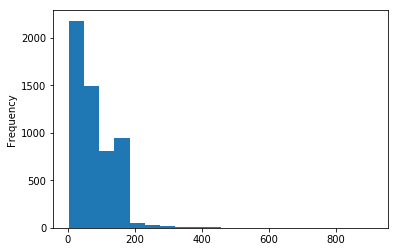

In [17]:
messages.length.plot(bins=20, kind='hist')

In [18]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

**What is that super long message?**

In [19]:
print(list(messages.message[messages.length > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


#### Is there any difference in message length between spam and ham?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000215D9D19EF0>,
      dtype=object)

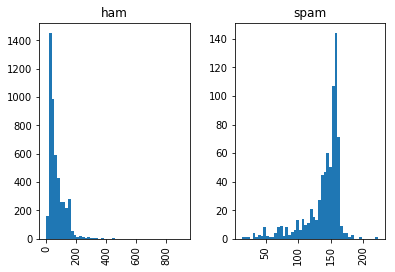

In [20]:
messages.hist(column='length', by='label', bins=50)

**How do we make computer understand the plain text messages? 
These algorithms require numbers**

## 2. Data preprocessing

- Convert the raw messages (sequence of characters) into vectors (sequences of numbers).

- The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

- As a first step, let's write a function that will split a message into its individual words:

In [21]:
# TextBlob require a tokenizer

# Use Punkt Sentence Tokenizer

# This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation
# words, collocations, and words that start sentences.  It must be
# trained on a large collection of plaintext in the target language
# before it can be used.

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lavet\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lavet\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [22]:
def split_into_tokens(message):
    #message = unicode(message, 'utf8')  # convert bytes into proper unicode - not required in python3
    return TextBlob(message).words

Here are some of the original texts again:
    

In [23]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

**...and here are the same messages, tokenized:**

In [24]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

#### NLP questions:

1. Do capital letters carry information?
2. Does distinguishing inflected form ("goes" vs. "go") carry information?

In other words, we want to better "normalize" the text.

With textblob, we'd detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [25]:
#TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

and normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) with:

In [26]:
# Lemmatisation (or lemmatization) in linguistics is the process 
# of grouping together the inflected forms of a word so they 
# can be analysed as a single item, identified by the word's lemma, 
# or dictionary form.

# For example, in English, the verb 'to walk' may appear as:
# 'walk', 'walked', 'walks', 'walking'. 
# The base form, 'walk', that one might look up in a dictionary, 
# is called the lemma for the word.

# a) Convert to lower case
# b) Split into words
# c) Find out the lemma

# For more info Refer:
# https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/

def split_into_lemmas(message):
    # message = unicode(message, 'utf8').lower()
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

We can think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.

## 3. Convert Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. TF - counting how many times does a word occur in each message (term frequency)
2. IDF - weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize - normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the SMS corpus:

In [32]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

8857


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [29]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [31]:
bow4 = bow_transformer.transform([message4])
print( bow4 )
print( bow4.shape )

So, nine unique words in message nr. 4, two of them appear twice, the rest only once. Sanity check: what are these words the appear twice?

In [19]:
print bow_transformer.get_feature_names()[6736]
print bow_transformer.get_feature_names()[8013]

say
u


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

In [39]:
messages_bow = bow_transformer.transform(messages['message'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 8857)
number of non-zeros: 80340
sparsity: 0.16%


#### TF-IDF Transformer
And finally, after the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`:

In [42]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 8000)	0.30500390244920195
  (0, 7685)	0.22530830435091123
  (0, 7099)	0.19139747787841085
  (0, 6724)	0.5233907074133691
  (0, 4015)	0.4563719925781256
  (0, 2921)	0.329688073969027
  (0, 2891)	0.30370462627268274
  (0, 1895)	0.24665241656533501
  (0, 1156)	0.27494440163841516


What is the IDF (inverse document frequency) of the word `"u"`? Of word `"university"`?

In [43]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

2.8495406039561364
8.239753235208429


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [44]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 8857)


There are a multitude of ways in which data can be proprocessed and vectorized. These two steps, also called "feature engineering", are typically the most time consuming and "un****" parts of building a predictive pipeline, but they are very important and require some experience. The trick is to evaluate constantly: analyze model for the errors it makes, improve data cleaning & preprocessing, brainstorm for new features, evaluate...

## 4. Train/Build a model

With messages represented as vectors, we can finally train our spam/ham classifier.

Choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [45]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 12.2 ms, sys: 3.79 ms, total: 16 ms
Wall time: 17.1 ms


## 5. Detecting spam messages

Let's try classifying our single random message:

In [46]:
print('predicted:', spam_detector.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


You can try it with your own text messages, too.

A natural question is to ask, how many messages do we classify correctly overall?

In [47]:
all_predictions = spam_detector.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


## 6. Evaluate the model (On Train Data)

#### Accuracy and Confusion Matrix

In [48]:
print('accuracy', accuracy_score(messages['label'], all_predictions))
print('confusion matrix\n', confusion_matrix(messages['label'], all_predictions))
print('(row=expected, col=predicted)')

accuracy 0.9695012558306423
confusion matrix
 [[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

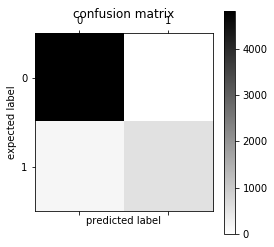

In [50]:
plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

#### Precision (P), Recall (R) and F1-Score
From this confusion matrix, we can compute precision and recall, or their combination (harmonic mean) F1:

The reported averages include:
- micro average (averaging the total true positives, false negatives and false positives), 

- macro average (averaging the unweighted mean per label), 

- weighted average (averaging the support-weighted mean per label) and sample average (only for multilabel classification). 

- Note that in binary classification, recall of the positive class
  s also known as "sensitivity"; recall of the negative class is
  "specificity".

In [51]:
print(classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      4827
        spam       1.00      0.77      0.87       747

   micro avg       0.97      0.97      0.97      5574
   macro avg       0.98      0.89      0.93      5574
weighted avg       0.97      0.97      0.97      5574



There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".

## 7. How to run experiments? - Pipeline

In the above "evaluation", we committed a cardinal sin. For simplicity of demonstration, we evaluated accuracy on the same data we used for training. **Never evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way, and that our final evaluation on test data is representative of true predictive performance.

#### Split the data into train and test
The test size is 20% of the entire dataset (1115 messages out of total 5574), and the remaining 80% training set is the rest (4459 out of 5574).

In [52]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


#### Putting all the steps explicitly into scikit-learn's `Pipeline`:

In [53]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

#### K-Fold cross validation

- A common practice is to partition the training set again, into smaller subsets; for example, 5 equally sized subsets. Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). Repeated five times (taking different part for evaluation each time).

- we get a sense of model "stability". If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). Go back, analyze errors, re-check input data for garbage, re-check data cleaning.

In [54]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores) # Print the accuracies of 5-folds of data

[0.950783   0.950783   0.97309417 0.93497758 0.94843049 0.94618834
 0.94618834 0.96404494 0.94157303 0.95280899]


The scores are indeed a little bit worse than when we trained on the entire dataset (5574 training examples, accuracy 0.97). They are fairly stable though:

In [55]:
print(scores.mean(), scores.std())

0.9508871885584679 0.010295894615586446


#### how can we improve this model? The scores are already high here, but how would we go about improving a model in general?

- Naive Bayes is an example of a [high bias - low variance](http://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) classifier (aka simple and stable, not prone to overfitting). 

- An example from the opposite side of the spectrum would be Nearest Neighbour (kNN) classifiers, or Decision Trees, with their low bias but high variance (easy to overfit). 

- Bagging (Random Forests) as a way to lower variance, by training many (high-variance) models and averaging.

#### Overfitting Example:

[![](http://radimrehurek.com/data_science_python/plot_bias_variance_examples_2.png)](http://www.astroml.org/sklearn_tutorial/practical.html#bias-variance-over-fitting-and-under-fitting)

In other words:

* **high bias** = classifer is opinionated. Not as much room to change its mind with data, it has its own ideas. On the other hand, not as much room it can fool itself into overfitting either (picture on the left).
* **low bias** = classifier more obedient, but also more neurotic. Will do exactly what you ask it to do, which, as everybody knows, can be a real nuisance (picture on the right).

#### Understand the learning patter of the model
#### Useing learning curve

In [56]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 130 ms, sys: 28.2 ms, total: 159 ms
Wall time: 18.1 s


<module 'matplotlib.pyplot' from '/home/ramesh/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

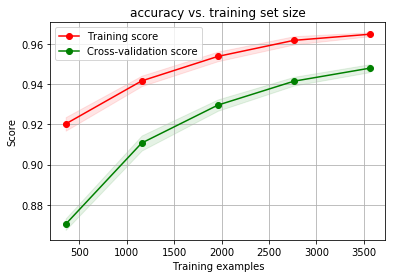

In [57]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

(We're effectively training on 64% of all available data: we reserved 20% for the test set above, and the 5-fold cross validation reserves another 20% for validation sets => `0.8*0.8*5574=3567` training examples left.)

- In the learning curve, we have noticed that the **performance of the model keeps growing, both for training and cross validation scores**

- we see our **model is not complex enough to capture all nuance, given little data.** 

- In this particular case, it's not very pronounced, since **the accuracies are high anyway.**

#### At this point, we have two options/solutions:

1. **use more training data**, to overcome low model complexity
2. **use a more complex (lower bias) model** to start with, to get more out of the existing data

Over the last years, as massive training data collections become more available, and as machines get faster, approach 1. is becoming more and more popular (simpler algorithms, more data). Straightforward algorithms, such as Naive Bayes, also have the added benefit of being easier to interpret (compared to some more complex, black-box models, like neural networks).

Knowing how to evaluate models properly, we can now explore how different parameters affect the performace.

## 8. How to tune parameters?
### Use GridSearchCV

What we've seen so far is only a tip of the iceberg: there are many other parameters to tune. One example is what algorithm to use for training.

We've used Naive Bayes above, but scikit-learn supports many classifiers out of the box: Support Vector Machines, Nearest Neighbours, Decision Trees, Ensamble methods...

[![](http://radimrehurek.com/data_science_python/drop_shadows_background.png)](http://peekaboo-vision.blogspot.cz/2013/01/machine-learning-cheat-sheet-for-scikit.html)

We can ask: What is the effect of IDF weighting on accuracy? Does the extra processing cost of lemmatization (vs. just plain words) really help?

Let's find out:

In [73]:
label_train.shape

(4459,)

In [74]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

#skf = StratifiedKFold(label_train, n_splits=5, shuffle=True)

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(shuffle = True, n_splits=5),  # what type of cross validation to use
    #cv=skf
)

In [89]:
%time nb_detector = grid.fit(msg_train, label_train)

CPU times: user 1.81 s, sys: 23.3 ms, total: 1.84 s
Wall time: 22.7 s


In [90]:
print(nb_detector.best_score_)
print(nb_detector.best_estimator_)

0.9472976003588248
Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function split_into_lemmas at 0x7f44600b46a8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocess...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])


(best parameter combinations are displayed first: in this case, `use_idf=True` and `analyzer=split_into_lemmas` ).

#### Make Predictions: Check the probability of predictions by the best model

In [88]:
print(nb_detector.predict_proba(["Hi mom, how are you?"])[0])
print(nb_detector.predict_proba(["WINNER! Credit for free!"])[0])

[0.99046173 0.00953827]
[0.65182071 0.34817929]


The `predict_proba` returns the predicted probability for each class (ham, spam). In the first case, the message is predicted to be ham with > 99% probability, and spam with < 1%. So if forced to choose, the model will say "ham":

In [40]:
print(nb_detector.predict(["Hi mom, how are you?"])[0])
print(nb_detector.predict(["WINNER! Credit for free!"])[0])

ham
spam


### Evaluate on test set
And overall scores on the test set, the one we haven't used at all during training:

In [91]:
predictions = nb_detector.predict(msg_test)
print(confusion_matrix(label_test, predictions))
print(classification_report(label_test, predictions))

[[960   0]
 [ 66  89]]
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       960
        spam       1.00      0.57      0.73       155

   micro avg       0.94      0.94      0.94      1115
   macro avg       0.97      0.79      0.85      1115
weighted avg       0.94      0.94      0.93      1115



The reported averages include:
- micro average (averaging the total true positives, false negatives and false positives), 

- macro average (averaging the unweighted mean per label), 

- weighted average (averaging the support-weighted mean per label) and sample average (only for multilabel classification). 

- Note that in binary classification, recall of the positive class
  s also known as "sensitivity"; recall of the negative class is
  "specificity".

This is then the realistic predictive performance we can expect from our spam detection pipeline, when using lowercase with lemmatization, TF-IDF and Naive Bayes for classifier.

## 9. Using SVM
Let's try with another classifier: [Support Vector Machines (SVM)](http://en.wikipedia.org/wiki/Support_vector_machine). SVMs are a great starting point when classifying text data, getting state of the art results very quickly and with pleasantly little tuning (although a bit more than Naive Bayes):

In [94]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(shuffle = True, n_splits=5),  # what type of cross validation to use
)

In [97]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm

CPU times: user 2.62 s, sys: 15.7 ms, total: 2.63 s
Wall time: 1min 11s


So apparently, linear kernel with `C=1` is the best parameter combination.

Sanity check again:

In [44]:
print(svm_detector.predict(["Hi mom, how are you?"])[0])
print(svm_detector.predict(["WINNER! Credit for free!"])[0])

ham
spam


In [45]:
print(confusion_matrix(label_test, svm_detector.predict(msg_test)))
print(classification_report(label_test, svm_detector.predict(msg_test)))

[[965   8]
 [ 13 129]]
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99       973
       spam       0.94      0.91      0.92       142

avg / total       0.98      0.98      0.98      1115



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using SVMs.

## 10. Productionalizing a Model

With basic analysis and tuning done, the real work (engineering) begins.

The final step for a production predictor would be training it on the entire dataset again, to make full use of all the data available. We'd use the best parameters found via cross validation above, of course. This is very similar to what we did in the beginning, but this time having insight into its behaviour and stability. Evaluation was done honestly, on distinct train/test subset splits.

The final predictor can be serialized to disk, so that the next time we want to use it, we can skip all training and use the trained model directly:

In [46]:
# store the spam detector to disk after training
with open('sms_spam_detector.pkl', 'wb') as fout:
    cPickle.dump(svm_detector, fout)

# ...and load it back, whenever needed, possibly on a different machine
svm_detector_reloaded = cPickle.load(open('sms_spam_detector.pkl'))

The loaded result is an object that behaves identically to the original:

In [47]:
print 'before:', svm_detector.predict([message4])[0]
print 'after:', svm_detector_reloaded.predict([message4])[0]

before: ham
after: ham


# 11. Other practical considerations

- data sparsity

- online learning, data streams

- `mmap` for memory sharing, system "cold-start" load times

- scalability, distributed (cluster) processing

## TODO

- Explore and implement other hyper paramter optimization methods
- Explore other binary classifiers such as Logistic Regression